In [14]:
%reload_ext autoreload
%autoreload 2

import os

# Update to the root of the project
os.chdir("/juno/u/heppert/code/articulated_fg_release")
print(f"Changed dir to {os.getcwd()}")

import pathlib
import pickle
from typing import Any, Dict, List, Optional, Tuple

import evaluation.helpers
import helpers

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as onp
import pandas as pd
from evaluation import eval
import experiment_files
import matplotlib
import tqdm
import seaborn as sns

Changed dir to /juno/u/heppert/code/articulated_fg_release


In [15]:
def append_experiment(
    data: Dict["str", List],
    experiment_identifier: str,
    experiment_path: str,
    methods: Dict[str, str],
) -> None:
    def append_sample(
        data: Dict["str", List],
        config_loaded: "only_poses.config.FullPoseConfig",
        method: str,
        similarity_score: float,
        angle_error: float,
    ) -> None:
        if "motion_type" not in data:
            data["motion_type"] = []
            data["stddev_pos"] = []
            data["stddev_ori"] = []
            data["motion_range"] = []
            data["num_observations"] = []
            data["method"] = []
            data["similarity_score"] = []
            data["angle_error"] = []
        data["motion_type"].append(config_loaded.motion_type.value)
        data["stddev_pos"].append(config_loaded.stddev_pos)
        data["stddev_ori"].append(config_loaded.stddev_ori * 180 / onp.pi)
        data["motion_range"].append(config_loaded.sample_length)
        data["num_observations"].append(config_loaded.observation_amount)
        data["method"].append(method)
        data["similarity_score"].append(similarity_score)
        data["angle_error"].append(angle_error)

    experiment = experiment_files.ExperimentFiles(
        experiment_identifier, root_path=experiment_path, verbose=False
    )
    error_dict = experiment.read_metadata("error_dict")["errors"]
    config_loaded = experiment.read_metadata("config")

    for method, method_key in methods.items():
        # if error_dict[method_key].shape[0] < 50:
        #     print(
        #         f"Too little samples {experiment_identifier = } {error_dict[method_key].shape = }"
        #     )
        #     continue

        for similarity_score, angle_error in error_dict[method_key]:
            append_sample(
                data,
                config_loaded,
                method,
                similarity_score,
                angle_error * 180 / onp.pi,
            )

In [16]:
root_path = "./experiments/only_poses/"

data = {}
experiment_identifiers = os.listdir(root_path)
for experiment_identifier in tqdm.tqdm(experiment_identifiers):
    append_experiment(
        data,
        experiment_identifier,
        root_path,
        {"fg": "pred_fg_twist", "sturm": "pred_sturm_original_twist"},
    )

df = pd.DataFrame(data)
df

100%|██████████| 1/1 [00:00<00:00, 55.95it/s]


,motion_type,stddev_pos,stddev_ori,motion_range,num_observations,method,similarity_score,angle_error
0,translation,0.03,0.572958,0.5,10,fg,0.993793,6.385343
1,translation,0.03,0.572958,0.5,10,fg,0.988613,8.654726
2,translation,0.03,0.572958,0.5,10,fg,0.997186,4.291140
3,translation,0.03,0.572958,0.5,10,fg,0.996915,4.483448
4,translation,0.03,0.572958,0.5,10,fg,0.998873,2.707652
5,translation,0.03,0.572958,0.5,10,fg,0.999789,1.140740
6,translation,0.03,0.572958,0.5,10,fg,0.999225,2.255123
7,translation,0.03,0.572958,0.5,10,fg,0.995675,5.327646
8,translation,0.03,0.572958,0.5,10,fg,0.995187,5.612718
9,translation,0.03,0.572958,0.5,10,fg,0.997030,4.413419


In [17]:
marker_styles = {"fg": "o", "sturm": "^"}
# marker_styles = {"fg": "", "sturm": ""}


def quantile_lineplot(
    ax: plt.Axes,
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    ci: Tuple[int, int],
    err_kws: Dict[str, Any],
    **kw,
) -> None:
    categories = data[hue].unique()
    for category in categories:
        df_cat = data[data[hue] == category]
        grouped = df_cat.groupby([x])

        df_lower = grouped[y].quantile(ci[0] / 100).reset_index()
        df_middle = grouped[y].median().reset_index()
        df_upper = grouped[y].quantile(ci[1] / 100).reset_index()

        ax.fill_between(df_lower[x], df_lower[y], df_upper[y], **err_kws)
        ax.plot(
            df_middle[x],
            df_middle[y],
            label=category,
            marker=marker_styles[category],
            **kw,
        )

    ax.legend()


def lineplot(
    ax: plt.Axes,
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    labels: List[str] = [],
    plot_quantiles: bool = True,
) -> None:
    if plot_quantiles:
        quantile_lineplot(
            ax=ax,
            data=data,
            x=x,
            y="similarity_score",
            hue="method",
            ci=(25, 75),
            err_kws={"alpha": 0.1},
        )
    else:
        sns.lineplot(
            ax=ax,
            data=data,
            x=x,
            y="similarity_score",
            hue="method",
            ci="sd",
            err_kws={"alpha": 0.1},
        )

    legend = ax.legend()
    for text, label in zip(legend.texts, labels):
        text.set_text(label)

    x_min = data[x].min()
    x_max = min(200, data[x].max())
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([0, 1.001])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(None)
    ax.spines["top"].set_visible(False)


def plot_only_poses(
    data: pd.DataFrame, joint_type: str, path: str, save: bool = True
) -> None:
    assert joint_type in ["prismatic", "revolute"]

    sns.set_theme(style="whitegrid")
    plt.rcParams["font.family"] = "Times New Roman"

    fig, axs = plt.subplots(1, 4, figsize=(12, 2.7), dpi=300)
    fig.suptitle(f"{joint_type.capitalize()} Joints", y=0.91)
    fig.supylabel("Tangent Similarity", fontsize="medium", x=0.01, y=0.51)

    motion_type = "translation" if joint_type == "prismatic" else "rotation"
    idx_joint = data["motion_type"] == motion_type
    df = data[idx_joint]

    methods = ["Factor Graph (ours)", "Sturm et al."]
    motion_unit = "m" if joint_type == "prismatic" else "deg"
    lineplot(axs[0], df, x="num_observations", xlabel="# Observations", labels=methods)
    lineplot(
        axs[1],
        df,
        x="motion_range",
        xlabel=f"Motion Range [{motion_unit}]",
        labels=methods,
    )
    lineplot(
        axs[2],
        df,
        x="stddev_pos",
        xlabel="Position Standard Deviation [m]",
        labels=methods,
    )
    lineplot(
        axs[3],
        df,
        x="stddev_ori",
        xlabel="Orientation Standard Deviation [deg]",
        labels=methods,
    )

    plt.tight_layout(pad=0.9)

    fig_path = pathlib.Path(path) / f"only_poses_{joint_type}.pdf"
    if save:
        fig.savefig(fig_path, bbox_inches="tight", pad_inches=0)

/tmp/user/20943/ipykernel_2338773/1394937235.py:47: UserWarning: Attempting to set identical left == right == 10 results in singular transformations; automatically expanding.
  ax.set_xlim([x_min, x_max])
/tmp/user/20943/ipykernel_2338773/1394937235.py:47: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim([x_min, x_max])
/tmp/user/20943/ipykernel_2338773/1394937235.py:47: UserWarning: Attempting to set identical left == right == 0.03 results in singular transformations; automatically expanding.
  ax.set_xlim([x_min, x_max])
/tmp/user/20943/ipykernel_2338773/1394937235.py:47: UserWarning: Attempting to set identical left == right == 0.5729577951308232 results in singular transformations; automatically expanding.
  ax.set_xlim([x_min, x_max])
No handles with labels found to put in legend.
No handles with labels found to put in legend.


ValueError: Axis limits cannot be NaN or Inf

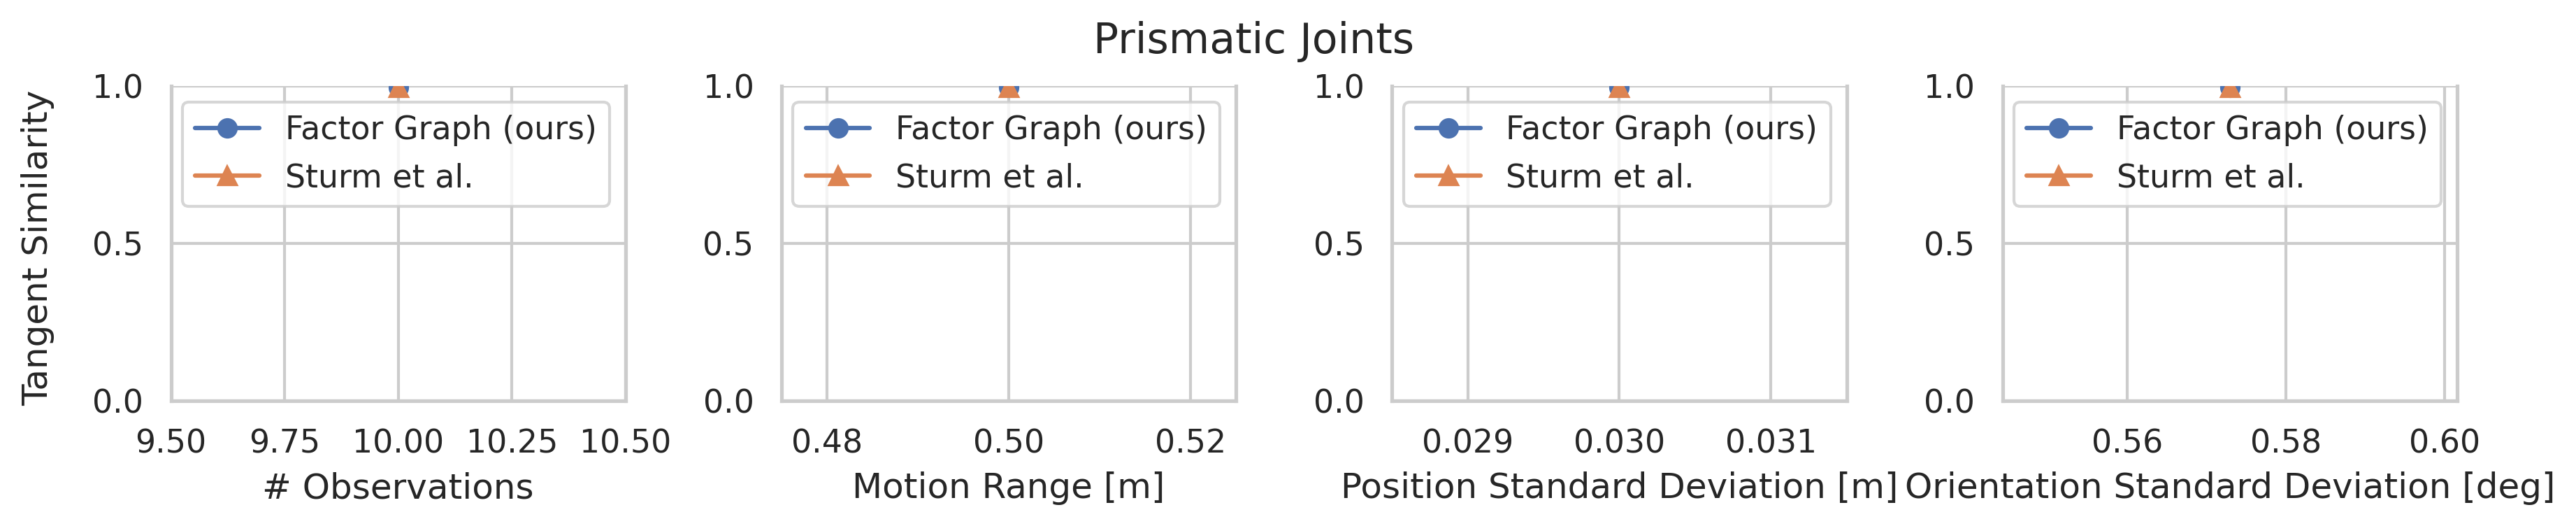

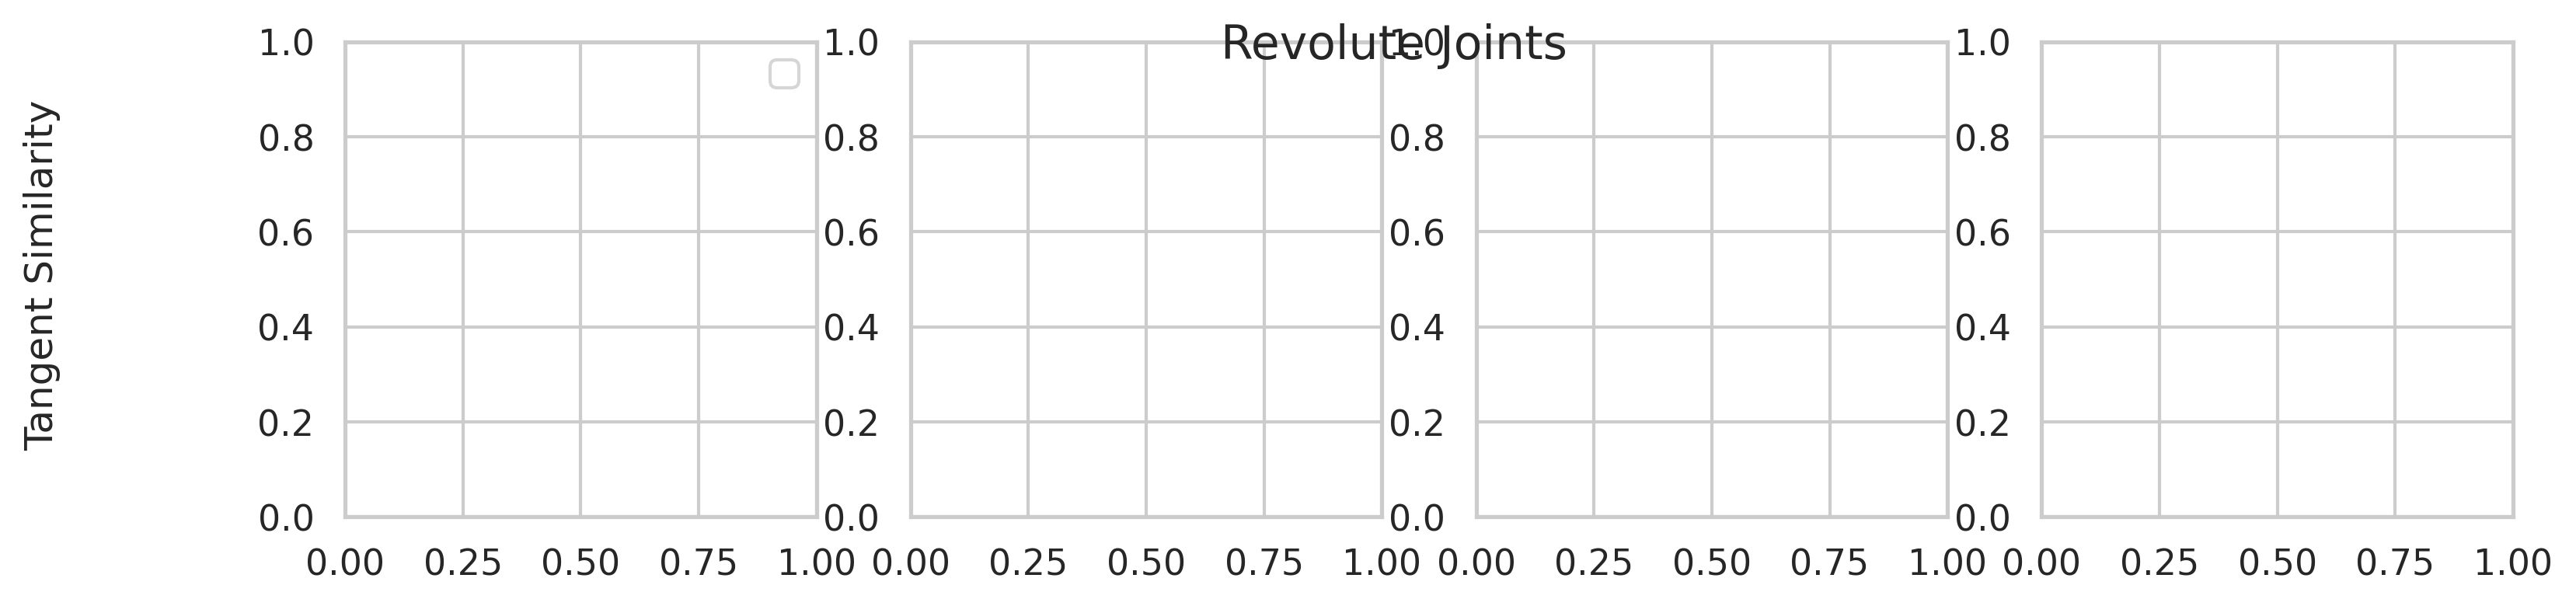

In [18]:
plot_save_path = "only_poses/plots/"
os.makedirs(plot_save_path, exist_ok=True)

plot_only_poses(df, "prismatic", plot_save_path, save=False)
plot_only_poses(df, "revolute", plot_save_path, save=False)